# EAS: Entrenamiento

El objetivo de este trabajo es la localización y segmentación de **paneles fotovoltaicos y colectores solares.**

Como datos iniciales, se recopiló una lista de puntos georreferenciados (aproximados) de paneles y colectores, y a partir de estos, se tomó una muestra y se marcaron polígonos de paneles y colectores. Los polígonos delimitan el contorno de los objetos de interés.

El método de análisis y predicción está dado por el modelo de machine learning **U-Net**, especializado en **segmentación semántica**, por lo tanto se requieren anotaciones de polígonos.

**En estos notebooks se va a hacer foco principalmente en los modelos para la detección de paneles.** Se exploró la detección y clasificación de colectores solares en el notebook [5 - Colectores](5_Colectores.ipynb).

## Preparación de datos

Los datos de entrenamiento se componen de dos partes: las imágenes y las máscaras. Las máscaras marcan la región de interés de cada imagen. Por ejemplo, marca donde hay un conjunto de módulos de paneles. Cada imagen debe poseer su correspondiente máscara.

![](img/sample_chip_mask.jpg)

Como el objetivo era analizar toda la cobertura a nivel nacional, pero también aprovechar la mayor resolución espacial de la ortoimagen urbana, se entrenaron dos modelos:

1. **Modelo 1: Urbana** - basado en la ortoimagen urbana de 10cm
2. **Modelo 2: Nacional** - basado en la ortoimagen nacional de 30cm

Para entrenar cada uno de los modelos, vamos a descargar imágenes tanto de la ortoimagen nacional como la urbana. Aprovechando que `ideuy` nos permite descargar sólo las imágenes que necesitamos para el entrenamiento, utilizaremos el mismo shapefile de anotaciones para filtrar la grilla urbana y nacional y descargar sólo esas hojas.

Los archivos vectoriales de anotaciones se encuentran en `data/paneles/shp/` y son:

* `paneles_nac_pol.geojson`: Paneles en cobertura nacional
* `paneles_urb_pol.geojson`: Paneles en cobertura urbana
* `paneles_nacurb_pol.geojson`: La unión de los dos anteriores GeoJSONs

El tercer GeoJSON es la unión de los dos anteriores, y va a ser utilizada por el modelo 2.

In [22]:
DATA_DIR = "data/paneles"

In [23]:
!ls $DATA_DIR/shp

paneles_nac_pol.geojson  paneles_nacurb_pol.geojson  paneles_urb_pol.geojson


In [3]:
# Instalamos ideuy
!pip install -U ideuy

     |████████████████████████████████| 503 kB 3.4 MB/s eta 0:00:01


In [4]:
# Reproyectamos a epsg:5381 (requerimiento de ideuy_filter)
!ogr2ogr -f GeoJSON -t_srs epsg:5381 /tmp/paneles_urb_pol_5381.geojson $DATA_DIR/shp/paneles_urb_pol.geojson 
!ogr2ogr -f GeoJSON -t_srs epsg:5381 /tmp/paneles_nacurb_pol_5381.geojson $DATA_DIR/shp/paneles_nacurb_pol.geojson 

Warning 1: Several features with id = 1 have been found. Altering it to be unique. This warning will not be emitted for this layer


In [5]:
# Generamos la grilla filtrada para urbano
!ideuy_filter -t urban \
              -o /tmp/paneles_urb_grilla.geojson \
              -v \
              /tmp/paneles_urb_pol_5381.geojson

In [6]:
# ...y para nacional
!ideuy_filter -t national \
              -o /tmp/paneles_nacurb_grilla.geojson \
              -v \
              /tmp/paneles_nacurb_pol_5381.geojson

In [7]:
# Descargamos las hojas de la imagen urbana
!ideuy_download \
    -t urban \
    -p rgb_8bit \
    -j4 \
    -v \
    -o $DATA_DIR/urban/raw_images \
    /tmp/paneles_urb_grilla.geojson

  0%|                                                    | 0/42 [00:00<?, ?it/s][2020-10-14 20:54:19] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_04/02_Ortoimagenes/04_Ciudad_LPS/03_RGB_8bits/K29B2N9_RGB_8_Remesa_04_LPS.jpg to data/paneles/urban/raw_images
[2020-10-14 20:54:19] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_01/02_Ortoimagenes/01_Ciudad_MVD/03_RGB_8bits/K29B5M3_RGB_8_Remesa_01_MVD.jpg to data/paneles/urban/raw_images
[2020-10-14 20:54:19] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_01/02_Ortoimagenes/01_Ciudad_MVD/03_RGB_8bits/K29B5N1_RGB_8_Remesa_01_MVD.jpg to data/paneles/urban/raw_images
[2020-10-14 20:54:19] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_01/02_Ortoimagenes/01_Ciudad_MVD/03_RGB_8bits/K29B5P9_RGB_8_Remesa_01_MVD.jpg to data/paneles/urban/raw_images
[2020-10-14 20:54:22] INFO:ideuy.download:Download https

[2020-10-14 20:54:28] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_01/02_Ortoimagenes/01_Ciudad_MVD/03_RGB_8bits/J29C1O8_RGB_8_Remesa_01_MVD.jgw to data/paneles/urban/raw_images
[2020-10-14 20:54:28] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_01/02_Ortoimagenes/01_Ciudad_MVD/03_RGB_8bits/J29C4N5_RGB_8_Remesa_01_MVD.jgw to data/paneles/urban/raw_images
[2020-10-14 20:54:29] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_01/02_Ortoimagenes/01_Ciudad_MVD/03_RGB_8bits/J29C4M8_RGB_8_Remesa_01_MVD.jgw to data/paneles/urban/raw_images
[2020-10-14 20:54:29] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_01/02_Ortoimagenes/01_Ciudad_MVD/03_RGB_8bits/J29C5M2_RGB_8_Remesa_01_MVD.jpg to data/paneles/urban/raw_images
 40%|█████████████████▍                         | 17/42 [00:10<00:17,  1.40it/s][2020-10-14 20:54:29] INFO:ideuy.download:Download https

 76%|████████████████████████████████▊          | 32/42 [00:16<00:04,  2.37it/s][2020-10-14 20:54:35] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_07/02_Ortoimagenes/13_Ciudad_SJM/03_RGB_8bits/L26C6N3_RGB_8_Remesa_07_SJM.jgw to data/paneles/urban/raw_images
[2020-10-14 20:54:35] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_08/02_Ortoimagenes/06_Ciudad_NPA/03_RGB_8bits/R24B2P1_RGB_8_Remesa_08_NPA.jpg to data/paneles/urban/raw_images
 79%|█████████████████████████████████▊         | 33/42 [00:16<00:03,  2.58it/s][2020-10-14 20:54:35] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_08/02_Ortoimagenes/05_Ciudad_MER/03_RGB_8bits/P20D2P8_RGB_8_Remesa_08_MER.jgw to data/paneles/urban/raw_images
[2020-10-14 20:54:36] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_08/02_Ortoimagenes/05_Ciudad_MER/03_RGB_8bits/P20D5N3_RGB_8_Remesa_08_MER.jgw to data/p

In [8]:
# ...y las de la imagen nacional
!ideuy_download \
    -t national \
    -p rgb_8bit \
    -j4 \
    -v \
    -o $DATA_DIR/national/raw_images \
    /tmp/paneles_nacurb_grilla.geojson

  0%|                                                    | 0/60 [00:00<?, ?it/s][2020-10-14 20:54:40] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_08/02_Ortoimagenes/03_RGB_8bits/E13D2_RGB_8_Remesa_08.jpg to data/paneles/national/raw_images
[2020-10-14 20:54:40] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_10/02_Ortoimagenes/03_RGB_8bits/N10C4_RGB_8_Remesa_10.jpg to data/paneles/national/raw_images
[2020-10-14 20:54:40] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_03/02_Ortoimagenes/03_RGB_8bits/O20A1_RGB_8_Remesa_03.jpg to data/paneles/national/raw_images
[2020-10-14 20:54:40] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_03/02_Ortoimagenes/03_RGB_8bits/P25D6_RGB_8_Remesa_03.jpg to data/paneles/national/raw_images
[2020-10-14 20:54:41] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_10/02_Ortoimagenes/

[2020-10-14 20:54:47] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_03/02_Ortoimagenes/03_RGB_8bits/P22A5_RGB_8_Remesa_03.jgw to data/paneles/national/raw_images
[2020-10-14 20:54:48] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_03/02_Ortoimagenes/03_RGB_8bits/O24A4_RGB_8_Remesa_03.jpg to data/paneles/national/raw_images
 32%|█████████████▌                             | 19/60 [00:08<00:13,  2.96it/s][2020-10-14 20:54:49] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_01/02_Ortoimagenes/03_RGB_8bits/K29A6_RGB_8_Remesa_01.jgw to data/paneles/national/raw_images
[2020-10-14 20:54:49] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_03/02_Ortoimagenes/03_RGB_8bits/O24A4_RGB_8_Remesa_03.jgw to data/paneles/national/raw_images
[2020-10-14 20:54:49] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_03/02_Ortoimagenes/

 58%|█████████████████████████                  | 35/60 [00:14<00:09,  2.66it/s][2020-10-14 20:54:55] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_10/02_Ortoimagenes/03_RGB_8bits/L09C1_RGB_8_Remesa_10.jgw to data/paneles/national/raw_images
[2020-10-14 20:54:55] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_10/02_Ortoimagenes/03_RGB_8bits/O10A1_RGB_8_Remesa_10.jgw to data/paneles/national/raw_images
[2020-10-14 20:54:55] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_06/02_Ortoimagenes/03_RGB_8bits/J29A6_RGB_8_Remesa_06.jgw to data/paneles/national/raw_images
[2020-10-14 20:54:55] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_10/02_Ortoimagenes/03_RGB_8bits/O10A4_RGB_8_Remesa_10.jgw to data/paneles/national/raw_images
[2020-10-14 20:54:56] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_01/02_Ortoimagenes/

 87%|█████████████████████████████████████▎     | 52/60 [00:22<00:04,  1.71it/s][2020-10-14 20:55:02] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_03/02_Ortoimagenes/03_RGB_8bits/O20B4_RGB_8_Remesa_03.jpg to data/paneles/national/raw_images
[2020-10-14 20:55:02] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_03/02_Ortoimagenes/03_RGB_8bits/O20B2_RGB_8_Remesa_03.jpg to data/paneles/national/raw_images
 92%|███████████████████████████████████████▍   | 55/60 [00:22<00:01,  2.87it/s][2020-10-14 20:55:03] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_08/02_Ortoimagenes/03_RGB_8bits/J12A3_RGB_8_Remesa_08.jgw to data/paneles/national/raw_images
[2020-10-14 20:55:03] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_03/02_Ortoimagenes/03_RGB_8bits/O20B4_RGB_8_Remesa_03.jgw to data/paneles/national/raw_images
[2020-10-14 20:55:03] INFO:ideuy.download:Do

Una vez que haya terminado los dos procesos, deberíamos tener en el directorio `urban` y `national`, un directorio `raw_images` con las imágenes "crudas" de cada ortoimagen.

In [9]:
!tree -d data/paneles/

data/paneles/
├── national
│   └── raw_images
├── shp
└── urban
    ├── 400_100
    │   ├── images
    │   └── masks
    └── raw_images

8 directories


## Preprocesamiento


La generacion de las imagenes y mascaras se realiza vía *meduy_extract_chips*. Esta herramienta se utiliza tanto en la generación del dataset de entrenamiento como en el de predicción. En el primer caso se generan las imagenes y las mascaras, y en el segundo sólo las imagenes.

Primero, reproyectamos el geojson de anotaciones a epsg:5382, el mismo CRS que las imágenes.

In [17]:
!ogr2ogr -f GeoJSON -t_srs epsg:5382 \
    /tmp/paneles_urb_pol_5382.geojson \
    $DATA_DIR/shp/paneles_urb_pol.geojson 

!ogr2ogr -f GeoJSON -t_srs epsg:5382 \
    /tmp/paneles_nacurb_pol_5382.geojson \
    $DATA_DIR/shp/paneles_nacurb_pol.geojson     

Warning 1: Several features with id = 1 have been found. Altering it to be unique. This warning will not be emitted for this layer


Ahora, ejecutamos `meduy_extract_chips` para generar chips. Para cada modelo generamos chips de distinto tamaño, dado que las imagenes tienen diferente resolución. Despues de evaluar varios tamaños encontramos que los siguientes valores son óptimos para las imagenes y este problema:

* Urbano: 400px
* Nacional: 160px

Además, al entrenar, generamos chips con solapamiento para tener más información a la hora de entrenar, y para asegurarnos que el modelo entrene bien cuando los objetos queden en los bordes de la imagen.

* Urbano: 100px
* Nacional: 40px

Por otro lado, luego de varias pruebas, para el modelo 2 se decidió sumar las anotaciones de cobertura urbana. Por ende, para el modelo 2, se generaron chips usando los dos geojsons sobre las imagenes de cobertura nacional.

In [12]:
# Chips para entrenar modelo 1
!meduy_extract_chips \
    $DATA_DIR/urban/raw_images/*.jpg \
    $DATA_DIR/urban/raw_images/*.jp2 \
    -o $DATA_DIR/urban/400_100/ \
    --size 400 \
    --step-size 100 \
    --crs epsg:5382 \
    --labels /tmp/paneles_urb_pol_5382.geojson \
    --aoi /tmp/paneles_urb_pol_5382.geojson \
    -v

[2020-10-14 21:05:06] INFO:meduy.console.extract_chips:No rescale intensity
[2020-10-14 21:05:06] INFO:meduy.console.extract_chips:Extract chips
[2020-10-14 21:05:06] INFO:meduy.chips:Prepare AOI shape
[2020-10-14 21:05:06] INFO:meduy.chips:Prepare label shapes
  0%|                                                    | 0/42 [00:00<?, ?it/s][2020-10-14 21:05:06] INFO:meduy.chips:Raster size: (10307, 9508)
[2020-10-14 21:05:06] INFO:meduy.chips:Building windows
[2020-10-14 21:05:06] INFO:meduy.chips:Total windows: 9200
[2020-10-14 21:05:06] INFO:meduy.chips:Building window shapes
[2020-10-14 21:05:06] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:05:06] INFO:meduy.chips:Using "intersects" function
[2020-10-14 21:05:06] INFO:meduy.chips:Total windows after filtering: 34

  2%|█                                           | 1/42 [00:00<00:10,  3.88it/s][2020-10-14 21:05:06] INFO:meduy.chips:Raster size: (10253, 9429)
[2020-10-14 21:05:06] INFO:meduy.chips:Building windows
[2020-10

 31%|█████████████▎                             | 13/42 [00:06<00:15,  1.93it/s][2020-10-14 21:05:12] INFO:meduy.chips:Raster size: (10213, 9399)
[2020-10-14 21:05:12] INFO:meduy.chips:Building windows
[2020-10-14 21:05:12] INFO:meduy.chips:Total windows: 8910
[2020-10-14 21:05:12] INFO:meduy.chips:Building window shapes
[2020-10-14 21:05:13] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:05:13] INFO:meduy.chips:Using "intersects" function
[2020-10-14 21:05:13] INFO:meduy.chips:Total windows after filtering: 34

 33%|██████████████▎                            | 14/42 [00:07<00:14,  1.94it/s][2020-10-14 21:05:13] INFO:meduy.chips:Raster size: (10216, 9402)
[2020-10-14 21:05:13] INFO:meduy.chips:Building windows
[2020-10-14 21:05:13] INFO:meduy.chips:Total windows: 9009
[2020-10-14 21:05:13] INFO:meduy.chips:Building window shapes
[2020-10-14 21:05:13] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:05:13] INFO:meduy.chips:Using "intersects" function
[2020-10-14 21:05:

Los argumentos del comando son:

* **El primer argumento** es la ruta a las imágenes. Notar que le pasamos `*.jpg` y `\*.jp2`, esto es porque algunas imágenes de IDE están en formato JPEG2000, no JPG, y su extensión es `.jp2`, pero ambos formatos son válidos.*

* **-o** es la ruta del directorio destino. Recomendamos que dicha ruta sea descriptiva, por ejemplo `data_train/chips/400_100/Remesa08/ ” describe : `data_train` → datos usados para entrenar; `400_100` → `<tamaño de la imagen>_<tamaño del step_size>` (las imágenes son cuadradas); `Remesa08` → Remesa sobre la que vamos a trabajar.

* **--size** tamaño de las imágenes resultantes (las imágenes siempre son cuadradas) 
* **--step-size** paso del proceso. Si *step_size* es igual que el *size* entonces no hay overlap en las imágenes. 

En ocaciones es útil para el entrenamiento generar los chips con un overlap de este modo tenemos más datos para entrenar. Como mencionamos antes, para urbano hacemos 100px y 40px de overlap respectivamente. En la predicción valor puede ser igual al tamaño que la imagen, dado que con eso alcanza para cubrir toda la imagen entera.

* **--crs** le asigna un epsg a la imagen resultado. Para las imágenes del vuelo siempre debe ser `epsg:5382`. Esto es sólo necesario para las imágenes de formato JPG/JPEG2000, dado que no tienen CRS asociado.

* **--label-property** nombre de la columna donde se define cada categoría en el archivo vectorial (sólo se usa en el entrenamiento).

* **--classes** nombres de las clases (como aparecen en el geojson), separados por espacios.

* **--aoi** ruta al archivo vectorial con los polígonos de los paneles. Al definir una región de interes, sólo se procesan las imagenes que interceptan con los paneles. Es decir, no se generarán chips donde no haya paneles.

Este comando va a generar dos carpetas en la ruta de destino : "images" y "masks". Los archivos de la primera van a ser de tipo Tiff de 3 bandas (RGB) y los de la segunda van a ser también de tipo Tiff, pero de N bandas donde N representa el número de clases, en este caso 1, porque solo estamos interesados en segmentar paneles. Esta imagen de una banda es una máscara binaria.

In [18]:
# Chips para entrenar modelo 2
!meduy_extract_chips \
    $DATA_DIR/national/raw_images/*.jpg \
    -o $DATA_DIR/national/160_40/ \
    --size 160 \
    --step-size 40 \
    --crs epsg:5382 \
    --labels /tmp/paneles_nacurb_pol_5382.geojson \
    --aoi /tmp/paneles_nacurb_pol_5382.geojson \
    -v

[2020-10-14 21:09:18] INFO:meduy.console.extract_chips:No rescale intensity
[2020-10-14 21:09:18] INFO:meduy.console.extract_chips:Extract chips
[2020-10-14 21:09:18] INFO:meduy.chips:Prepare AOI shape
[2020-10-14 21:09:18] INFO:meduy.chips:Prepare label shapes
  0%|                                                    | 0/59 [00:00<?, ?it/s][2020-10-14 21:09:18] INFO:meduy.chips:Raster size: (19092, 17012)
[2020-10-14 21:09:18] INFO:meduy.chips:Building windows
[2020-10-14 21:09:18] INFO:meduy.chips:Total windows: 200028
[2020-10-14 21:09:18] INFO:meduy.chips:Building window shapes
[2020-10-14 21:09:21] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:09:21] INFO:meduy.chips:Using "intersects" function
[2020-10-14 21:09:27] INFO:meduy.chips:Total windows after filtering: 70

  2%|▋                                           | 1/59 [00:17<17:11, 17.78s/it][2020-10-14 21:09:36] INFO:meduy.chips:Raster size: (18449, 16954)
[2020-10-14 21:09:36] INFO:meduy.chips:Building windows
[202

[2020-10-14 21:11:14] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:11:14] INFO:meduy.chips:Using "intersects" function
[2020-10-14 21:11:29] INFO:meduy.chips:Total windows after filtering: 24

 10%|████▍                                       | 6/59 [02:15<20:24, 23.11s/it][2020-10-14 21:11:33] INFO:meduy.chips:Raster size: (18911, 16749)
[2020-10-14 21:11:33] INFO:meduy.chips:Building windows
[2020-10-14 21:11:34] INFO:meduy.chips:Total windows: 194635
[2020-10-14 21:11:34] INFO:meduy.chips:Building window shapes
[2020-10-14 21:11:37] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:11:37] INFO:meduy.chips:Using "intersects" function
[2020-10-14 21:11:51] INFO:meduy.chips:Total windows after filtering: 16

 12%|█████▏                                      | 7/59 [02:41<20:43, 23.91s/it][2020-10-14 21:11:59] INFO:meduy.chips:Raster size: (18305, 16765)
[2020-10-14 21:11:59] INFO:meduy.chips:Building windows
[2020-10-14 21:12:00] INFO:meduy.chips:Total windows: 188864


 15%|██████▋                                     | 9/59 [03:55<25:24, 30.50s/it][2020-10-14 21:13:13] INFO:meduy.chips:Raster size: (18296, 16765)
[2020-10-14 21:13:13] INFO:meduy.chips:Building windows
[2020-10-14 21:13:14] INFO:meduy.chips:Total windows: 188864
[2020-10-14 21:13:14] INFO:meduy.chips:Building window shapes
[2020-10-14 21:13:16] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:13:16] INFO:meduy.chips:Using "intersects" function
[2020-10-14 21:13:31] INFO:meduy.chips:Total windows after filtering: 122

 17%|███████▎                                   | 10/59 [04:22<24:02, 29.43s/it][2020-10-14 21:13:40] INFO:meduy.chips:Raster size: (18268, 16745)
[2020-10-14 21:13:40] INFO:meduy.chips:Building windows
[2020-10-14 21:13:41] INFO:meduy.chips:Total windows: 187995
[2020-10-14 21:13:41] INFO:meduy.chips:Building window shapes
[2020-10-14 21:13:43] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:13:43] INFO:meduy.chips:Using "intersects" function
[2020-10-14

 19%|████████                                   | 11/59 [04:49<22:56, 28.68s/it][2020-10-14 21:14:07] INFO:meduy.chips:Raster size: (18278, 16755)
[2020-10-14 21:14:07] INFO:meduy.chips:Building windows
[2020-10-14 21:14:08] INFO:meduy.chips:Total windows: 187995
[2020-10-14 21:14:08] INFO:meduy.chips:Building window shapes
[2020-10-14 21:14:10] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:14:10] INFO:meduy.chips:Using "intersects" function
[2020-10-14 21:14:25] INFO:meduy.chips:Total windows after filtering: 92

 20%|████████▋                                  | 12/59 [05:17<22:26, 28.66s/it][2020-10-14 21:14:36] INFO:meduy.chips:Raster size: (18626, 16675)
[2020-10-14 21:14:36] INFO:meduy.chips:Building windows
[2020-10-14 21:14:36] INFO:meduy.chips:Total windows: 190806
[2020-10-14 21:14:36] INFO:meduy.chips:Building window shapes
[2020-10-14 21:14:39] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:14:39] INFO:meduy.chips:Using "intersects" function
[2020-10-14 

 27%|███████████▋                               | 16/59 [07:02<19:04, 26.62s/it][2020-10-14 21:16:20] INFO:meduy.chips:Raster size: (18248, 16704)
[2020-10-14 21:16:20] INFO:meduy.chips:Building windows
[2020-10-14 21:16:20] INFO:meduy.chips:Total windows: 187542
[2020-10-14 21:16:20] INFO:meduy.chips:Building window shapes
[2020-10-14 21:16:23] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:16:23] INFO:meduy.chips:Using "intersects" function
[2020-10-14 21:16:37] INFO:meduy.chips:Total windows after filtering: 20

 29%|████████████▍                              | 17/59 [07:31<19:14, 27.49s/it][2020-10-14 21:16:49] INFO:meduy.chips:Raster size: (18277, 16724)
[2020-10-14 21:16:49] INFO:meduy.chips:Building windows
[2020-10-14 21:16:50] INFO:meduy.chips:Total windows: 187995
[2020-10-14 21:16:50] INFO:meduy.chips:Building window shapes
[2020-10-14 21:16:52] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:16:52] INFO:meduy.chips:Using "intersects" function
[2020-10-14 

 31%|█████████████                              | 18/59 [08:11<21:24, 31.34s/it][2020-10-14 21:17:30] INFO:meduy.chips:Raster size: (18258, 16714)
[2020-10-14 21:17:30] INFO:meduy.chips:Building windows
[2020-10-14 21:17:30] INFO:meduy.chips:Total windows: 187542
[2020-10-14 21:17:30] INFO:meduy.chips:Building window shapes
[2020-10-14 21:17:33] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:17:33] INFO:meduy.chips:Using "intersects" function
[2020-10-14 21:17:47] INFO:meduy.chips:Total windows after filtering: 16

 32%|█████████████▊                             | 19/59 [08:32<18:40, 28.01s/it][2020-10-14 21:17:50] INFO:meduy.chips:Raster size: (18268, 16724)
[2020-10-14 21:17:50] INFO:meduy.chips:Building windows
[2020-10-14 21:17:50] INFO:meduy.chips:Total windows: 187995
[2020-10-14 21:17:50] INFO:meduy.chips:Building window shapes
[2020-10-14 21:17:53] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:17:53] INFO:meduy.chips:Using "intersects" function
[2020-10-14 

[2020-10-14 21:18:55] INFO:meduy.chips:Total windows: 187995
[2020-10-14 21:18:55] INFO:meduy.chips:Building window shapes
[2020-10-14 21:18:57] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:18:57] INFO:meduy.chips:Using "intersects" function
[2020-10-14 21:19:11] INFO:meduy.chips:Total windows after filtering: 48

 37%|████████████████                           | 22/59 [10:06<18:24, 29.85s/it][2020-10-14 21:19:24] INFO:meduy.chips:Raster size: (18259, 16734)
[2020-10-14 21:19:24] INFO:meduy.chips:Building windows
[2020-10-14 21:19:25] INFO:meduy.chips:Total windows: 187995
[2020-10-14 21:19:25] INFO:meduy.chips:Building window shapes
[2020-10-14 21:19:27] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:19:27] INFO:meduy.chips:Using "intersects" function
[2020-10-14 21:19:42] INFO:meduy.chips:Total windows after filtering: 168

 39%|████████████████▊                          | 23/59 [10:42<18:56, 31.57s/it][2020-10-14 21:20:00] INFO:meduy.chips:Raster size: (18875, 

[2020-10-14 21:20:33] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:20:33] INFO:meduy.chips:Using "intersects" function
[2020-10-14 21:20:47] INFO:meduy.chips:Total windows after filtering: 73

 42%|██████████████████▏                        | 25/59 [11:34<16:04, 28.37s/it][2020-10-14 21:20:52] INFO:meduy.chips:Raster size: (19017, 16608)
[2020-10-14 21:20:52] INFO:meduy.chips:Building windows
[2020-10-14 21:20:53] INFO:meduy.chips:Total windows: 194464
[2020-10-14 21:20:53] INFO:meduy.chips:Building window shapes
[2020-10-14 21:20:55] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:20:55] INFO:meduy.chips:Using "intersects" function
[2020-10-14 21:21:10] INFO:meduy.chips:Total windows after filtering: 36

 44%|██████████████████▉                        | 26/59 [12:00<15:20, 27.90s/it][2020-10-14 21:21:19] INFO:meduy.chips:Raster size: (18933, 16590)
[2020-10-14 21:21:19] INFO:meduy.chips:Building windows
[2020-10-14 21:21:19] INFO:meduy.chips:Total windows: 193170


[2020-10-14 21:22:44] INFO:meduy.chips:Total windows: 195349
[2020-10-14 21:22:44] INFO:meduy.chips:Building window shapes
[2020-10-14 21:22:46] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:22:46] INFO:meduy.chips:Using "intersects" function
[2020-10-14 21:22:59] INFO:meduy.chips:Total windows after filtering: 25

 51%|█████████████████████▊                     | 30/59 [13:44<12:10, 25.20s/it][2020-10-14 21:23:03] INFO:meduy.chips:Raster size: (18892, 16680)
[2020-10-14 21:23:03] INFO:meduy.chips:Building windows
[2020-10-14 21:23:03] INFO:meduy.chips:Total windows: 193697
[2020-10-14 21:23:03] INFO:meduy.chips:Building window shapes
[2020-10-14 21:23:06] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:23:06] INFO:meduy.chips:Using "intersects" function
[2020-10-14 21:23:21] INFO:meduy.chips:Total windows after filtering: 35

 53%|██████████████████████▌                    | 31/59 [14:11<11:58, 25.67s/it][2020-10-14 21:23:29] INFO:meduy.chips:Raster size: (18422, 1

[2020-10-14 21:25:08] INFO:meduy.chips:Total windows after filtering: 61

 59%|█████████████████████████▌                 | 35/59 [16:03<11:04, 27.67s/it][2020-10-14 21:25:21] INFO:meduy.chips:Raster size: (18943, 16699)
[2020-10-14 21:25:21] INFO:meduy.chips:Building windows
[2020-10-14 21:25:22] INFO:meduy.chips:Total windows: 194580
[2020-10-14 21:25:22] INFO:meduy.chips:Building window shapes
[2020-10-14 21:25:24] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:25:24] INFO:meduy.chips:Using "intersects" function
[2020-10-14 21:25:39] INFO:meduy.chips:Total windows after filtering: 35

 61%|██████████████████████████▏                | 36/59 [16:24<09:53, 25.80s/it][2020-10-14 21:25:42] INFO:meduy.chips:Raster size: (18969, 16738)
[2020-10-14 21:25:42] INFO:meduy.chips:Building windows
[2020-10-14 21:25:43] INFO:meduy.chips:Total windows: 195465
[2020-10-14 21:25:43] INFO:meduy.chips:Building window shapes
[2020-10-14 21:25:46] INFO:meduy.chips:Filtering windows by AOI
[2020

 66%|████████████████████████████▍              | 39/59 [17:56<09:45, 29.27s/it][2020-10-14 21:27:15] INFO:meduy.chips:Raster size: (18749, 16734)
[2020-10-14 21:27:15] INFO:meduy.chips:Building windows
[2020-10-14 21:27:15] INFO:meduy.chips:Total windows: 192975
[2020-10-14 21:27:15] INFO:meduy.chips:Building window shapes
[2020-10-14 21:27:18] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:27:18] INFO:meduy.chips:Using "intersects" function
[2020-10-14 21:27:33] INFO:meduy.chips:Total windows after filtering: 35

 68%|█████████████████████████████▏             | 40/59 [18:25<09:11, 29.04s/it][2020-10-14 21:27:43] INFO:meduy.chips:Raster size: (18627, 16747)
[2020-10-14 21:27:43] INFO:meduy.chips:Building windows
[2020-10-14 21:27:44] INFO:meduy.chips:Total windows: 191730
[2020-10-14 21:27:44] INFO:meduy.chips:Building window shapes
[2020-10-14 21:27:46] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:27:46] INFO:meduy.chips:Using "intersects" function
[2020-10-14 

 73%|███████████████████████████████▎           | 43/59 [19:56<07:45, 29.07s/it][2020-10-14 21:29:15] INFO:meduy.chips:Raster size: (18566, 16749)
[2020-10-14 21:29:15] INFO:meduy.chips:Building windows
[2020-10-14 21:29:15] INFO:meduy.chips:Total windows: 191315
[2020-10-14 21:29:15] INFO:meduy.chips:Building window shapes
[2020-10-14 21:29:18] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:29:18] INFO:meduy.chips:Using "intersects" function
[2020-10-14 21:29:32] INFO:meduy.chips:Total windows after filtering: 20

 75%|████████████████████████████████           | 44/59 [20:25<07:15, 29.01s/it][2020-10-14 21:29:43] INFO:meduy.chips:Raster size: (18539, 16749)
[2020-10-14 21:29:43] INFO:meduy.chips:Building windows
[2020-10-14 21:29:44] INFO:meduy.chips:Total windows: 190900
[2020-10-14 21:29:44] INFO:meduy.chips:Building window shapes
[2020-10-14 21:29:46] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:29:46] INFO:meduy.chips:Using "intersects" function
[2020-10-14 

 81%|██████████████████████████████████▉        | 48/59 [22:24<05:30, 30.09s/it][2020-10-14 21:31:42] INFO:meduy.chips:Raster size: (18655, 16788)
[2020-10-14 21:31:42] INFO:meduy.chips:Building windows
[2020-10-14 21:31:42] INFO:meduy.chips:Total windows: 192608
[2020-10-14 21:31:42] INFO:meduy.chips:Building window shapes
[2020-10-14 21:31:45] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:31:45] INFO:meduy.chips:Using "intersects" function
[2020-10-14 21:32:00] INFO:meduy.chips:Total windows after filtering: 39

 83%|███████████████████████████████████▋       | 49/59 [22:45<04:35, 27.50s/it][2020-10-14 21:32:03] INFO:meduy.chips:Raster size: (18638, 16778)
[2020-10-14 21:32:03] INFO:meduy.chips:Building windows
[2020-10-14 21:32:04] INFO:meduy.chips:Total windows: 192192
[2020-10-14 21:32:04] INFO:meduy.chips:Building window shapes
[2020-10-14 21:32:06] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:32:06] INFO:meduy.chips:Using "intersects" function
[2020-10-14 

 90%|██████████████████████████████████████▋    | 53/59 [24:39<02:44, 27.48s/it][2020-10-14 21:33:57] INFO:meduy.chips:Raster size: (18585, 16789)
[2020-10-14 21:33:57] INFO:meduy.chips:Building windows
[2020-10-14 21:33:58] INFO:meduy.chips:Total windows: 191776
[2020-10-14 21:33:58] INFO:meduy.chips:Building window shapes
[2020-10-14 21:34:00] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:34:00] INFO:meduy.chips:Using "intersects" function
[2020-10-14 21:34:15] INFO:meduy.chips:Total windows after filtering: 39

 92%|███████████████████████████████████████▎   | 54/59 [24:59<02:06, 25.26s/it][2020-10-14 21:34:17] INFO:meduy.chips:Raster size: (18584, 16780)
[2020-10-14 21:34:17] INFO:meduy.chips:Building windows
[2020-10-14 21:34:18] INFO:meduy.chips:Total windows: 191776
[2020-10-14 21:34:18] INFO:meduy.chips:Building window shapes
[2020-10-14 21:34:20] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:34:20] INFO:meduy.chips:Using "intersects" function
[2020-10-14 

 97%|█████████████████████████████████████████▌ | 57/59 [26:22<00:53, 26.59s/it][2020-10-14 21:35:40] INFO:meduy.chips:Raster size: (18432, 16762)
[2020-10-14 21:35:40] INFO:meduy.chips:Building windows
[2020-10-14 21:35:41] INFO:meduy.chips:Total windows: 190112
[2020-10-14 21:35:41] INFO:meduy.chips:Building window shapes
[2020-10-14 21:35:43] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:35:43] INFO:meduy.chips:Using "intersects" function
[2020-10-14 21:35:58] INFO:meduy.chips:Total windows after filtering: 29

 98%|██████████████████████████████████████████▎| 58/59 [26:44<00:25, 25.37s/it][2020-10-14 21:36:03] INFO:meduy.chips:Raster size: (18560, 16832)
[2020-10-14 21:36:03] INFO:meduy.chips:Building windows
[2020-10-14 21:36:03] INFO:meduy.chips:Total windows: 191820
[2020-10-14 21:36:03] INFO:meduy.chips:Building window shapes
[2020-10-14 21:36:06] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 21:36:06] INFO:meduy.chips:Using "intersects" function
[2020-10-14 

In [24]:
!tree -d $DATA_DIR

data/paneles
├── national
│   ├── 160_40
│   │   ├── images
│   │   └── masks
│   └── raw_images
├── shp
└── urban
    ├── 400_100
    │   ├── images
    │   └── masks
    └── raw_images

11 directories


In [20]:
!ls $DATA_DIR/urban/400_100/images/ | wc -l

911


In [21]:
!ls $DATA_DIR/national/160_40/images/ | wc -l

3366


## Entrenamiento

Las librerías que importamos nos permite acceder a las herramientas que vamos a utilizar a lo largo del proyecto como por ejemplo la función de train y predict  del modelo de Unet 

In [26]:
from meduy.unet.train import TrainConfig, train
from meduy.unet.evaluate import plot_data_generator
import os

/home/ro/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ro/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ro/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ro/miniconda3/envs/tf-gpu/lib/python3.7/site-pack

En esta etapa debemos definir la configuración del modelo de ML. A continuación se muestran la mejor configuración encontrada para cada modelo:

In [27]:
# Modelo 1: Urbano
config = TrainConfig(width=320,     # tamaño de la imagen procesada por la UNet (debe ser multiplos de 16, por ej 160, 320, etc)
                     height=320,
                     n_channels=3,  # número de canales de la imagen, rgb -> 3
                     n_classes=1,   # número de clases
                     apply_image_augmentation=True,  # 
                     seed=42,
                     epochs=15,
                     batch_size=32,
                     steps_per_epoch=100,
                     early_stopping_patience=3,
                     validation_split=0.05,
                     images_path=os.path.join(DATA_DIR, 'urban', '400_100'),
                     model_path=os.path.join(DATA_DIR, 'weights', 'paneles_m1_v1.h5'))

Los parámetros son:
* `width`, `height`: Ancho y alto de las imágenes procesadas por la red U-Net. Debe ser múltiplo de 16.
* `n_channels`: Número de canales de la imagen, RGB -> 3
* `n_classes`: Número de clases (en este caso hay una sola clase "panel")
* `apply_image_augmentation`: Si es True, amplia el dataset generando imagenes nuevas a partir de pequeñas variaciones de las ya existentes, como cambios de brillo, contraste, rotaciones, etc.
* `epochs`: Cantidad de veces que el dataset entero puede pasar por el proceso de entrenamiento.
* `steps_per_epoch`: Cantidad de pasos por epoch. Típicamente debe ser igual al numero de imágenes / `batch_size`, si es mayor, incrementará el número de imágenes generadas con image augmentation. Notar que si es menor, un epoch no pasa necesariamente por todo el dataset disponible.
* `batch_size`: Cantidad de imágenes que se procesan a la vez dentro de la GPU, depende de la memoria de la GPU disponible, y está también ligado al ancho y alto de las imágenes. Por ejemplo, en un Tesla P100 entran hasta 32 imágenes de 320x320, pero no más. Si las imágenes fueran de 160x160, podrían entrar 64.
* `early_stopping_patience`: A medida que entrena se guarda los resultados del entrenamiento despues de cada epoch, si el error no varió luego de 3 iteraciones, se corta el proceso porque se entiende que el error ya disminuyó significativamente.
* `validation_split`: Se divide la muestra en training y validation para calcular el error durante el proceso de entrenamiento. Al finalizar cada epoch, se evalua sobre el dataset de validación y se calcula la métrica en ese conjunto de imágenes. Típicamente se usa una proporción 0.2 (20%) o 0.1 (10%), pero en este caso usamos el 5% porque hay pocos datos para entrenar.
* `images_path`: La ruta al directorio con los chips (images/ y masks/) para entrenar.
* `model_path`: La ruta donde se guardarán los pesos del mejor modelo entrenado (archivo con extensión `.h5`)

Antes de ponernos a entrenar, podemos visualizar alguna de las imagenes y mascaras de `images_path` con la siguiente función:

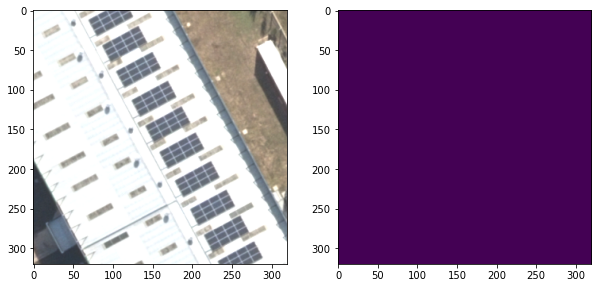

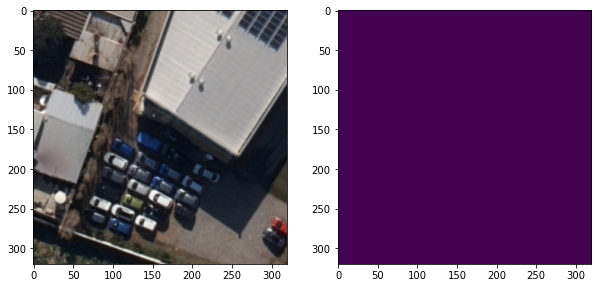

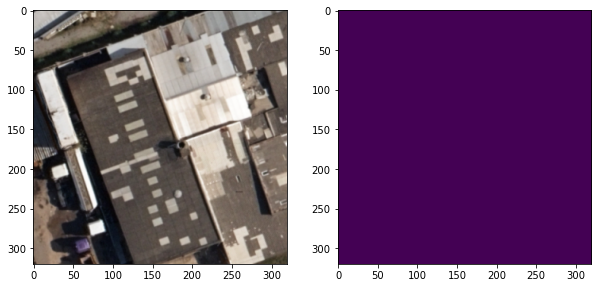

In [30]:
plot_data_generator(train_config=config, num_samples=3, fig_size=(10,10))

Ejecuta el entrenamiento

In [ ]:
train(config)